In [1]:
!pip install pytorch-lightning -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 28.8 MB/s eta 0:00:00


In [2]:
import os

from torch.nn import functional as F
from torchmetrics import Accuracy

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import Imagenette, ImageFolder
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl


Using DataModules class from Pytorch Lightning for creating the module for Imagenette dataset

In [3]:
# download dataset
Imagenette(root='./', download=True, split="train")

100%|██████████| 1557161267/1557161267 [00:30<00:00, 51224464.43it/s]


Extracting ./imagenette2.tgz to ./


Dataset Imagenette
    Number of datapoints: 9469
    Root location: ./

# Basic CNN

In [4]:
class ImagenetteDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def prepare_data(self):
        # Download or preprocess data if needed
        pass

    def setup(self, stage=None):
        dataset = ImageFolder(self.data_dir, transform=self.transform)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)


    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)


In [5]:
class BasicCNN(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


In [6]:
datamodule = ImagenetteDataModule(data_dir='/content/imagenette2/')
model = BasicCNN(num_classes=10)
trainer = pl.Trainer(max_epochs=5)  # Adjust max_epochs and gpus as needed
trainer.fit(model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 448   
1 | conv2 | Conv2d    | 4.6 K 
2 | fc1   | Linear    | 51.4 M
3 | fc2   | Linear    | 5.1 K 
4 | relu  | ReLU      | 0     
5 | pool  | MaxPool2d | 0     
------------------------------------
51.4 M    Trainable params
0         Non-trainable params
51.4 M    Total params
205.564   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [7]:
trainer.save_checkpoint("/content/basic_cnn_model.ckpt")

trainer.test(model, datamodule=datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9197461605072021     │
│         test_loss         │    0.30667415261268616    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.30667415261268616, 'test_acc': 0.9197461605072021}]

# Full Convolution

In [8]:
class AllCNN(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(96, 96, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(96, 192, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(192, 192, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(192, 192, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(192, num_classes, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.relu(self.conv5(x))
        x = self.conv6(x)
        x = self.global_pool(x)
        return x.view(x.size(0), -1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


In [9]:
datamodule = ImagenetteDataModule(data_dir='/content/imagenette2/')
model = AllCNN(num_classes=10)
trainer = pl.Trainer(max_epochs=5)  # Adjust max_epochs and gpus as needed
trainer.fit(model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type              | Params
--------------------------------------------------
0 | conv1       | Conv2d            | 2.7 K 
1 | conv2       | Conv2d            | 83.0 K
2 | conv3       | Conv2d            | 166 K 
3 | conv4       | Conv2d            | 331 K 
4 | conv5       | Conv2d            | 331 K 
5 | conv6       | Conv2d            | 17.3 K
6 | pool        | MaxPool2d         | 0     
7 | global_pool | AdaptiveAvgPool2d | 0     
8 | relu        | ReLU              | 0     
--------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [10]:
trainer.save_checkpoint("/content/all_cnn_model.ckpt")
trainer.test(model, datamodule=datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6965285539627075     │
│         test_loss         │    0.6151222586631775     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6151222586631775, 'test_acc': 0.6965285539627075}]

# Regularization model

In [11]:
class RegularizedCNN(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)  # Dropout probability of 0.5

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before the last fully connected layer
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


In [12]:
datamodule = ImagenetteDataModule(data_dir='/content/imagenette2/')
model = RegularizedCNN(num_classes=10)
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | conv1   | Conv2d    | 448   
1 | conv2   | Conv2d    | 4.6 K 
2 | fc1     | Linear    | 51.4 M
3 | fc2     | Linear    | 5.1 K 
4 | relu    | ReLU      | 0     
5 | pool    | MaxPool2d | 0     
6 | dropout | Dropout   | 0     
--------------------------------------
51.4 M    Trainable params
0         Non-trainable params
51.4 M    Total params
205.564   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [13]:
trainer.save_checkpoint("/content/regularised_cnn_model.ckpt")
trainer.test(model, datamodule=datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.882045567035675     │
│         test_loss         │    0.3390919268131256     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3390919268131256, 'test_acc': 0.882045567035675}]

# Transfer Learning model - using ResNet-50 as a pre-trained model

In [14]:
from torchvision.datasets import CIFAR10

class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir='./', batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
        ])

    def prepare_data(self):
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            cifar10_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar10_train, self.cifar10_val = random_split(cifar10_full, [45000, 5000])  # Split train/validation

        if stage == 'test' or stage is None:
            self.cifar10_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar10_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cifar10_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cifar10_test, batch_size=self.batch_size)


In [20]:
import matplotlib.pyplot as plt

class CIFAR10Classifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())  # Append training loss
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss)
        self.val_losses.append(loss.item())  # Append validation loss
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [21]:
import torchvision.models as models
import pytorch_lightning as pl

# Define the pre-trained ResNet18 model
imagenette_pretrained_resnet = models.resnet18(pretrained=True)
# Modify the last layer for CIFAR10
imagenette_pretrained_resnet.fc = nn.Linear(imagenette_pretrained_resnet.fc.in_features, 10)

# Freeze all layers except the last few layers for fine-tuning
for param in imagenette_pretrained_resnet.parameters():
    param.requires_grad = False
for param in imagenette_pretrained_resnet.layer4.parameters():
    param.requires_grad = True

# Define the CIFAR10 data module
datamodule_cifar10 = CIFAR10DataModule(data_dir='./')

# Instantiate the CIFAR10Classifier for transfer learning
model_transfer_learning = CIFAR10Classifier(imagenette_pretrained_resnet)

# Instantiate Trainer and train the model
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model_transfer_learning, datamodule=datamodule_cifar10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
8.4 M     Trainable params
2.8 M     Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


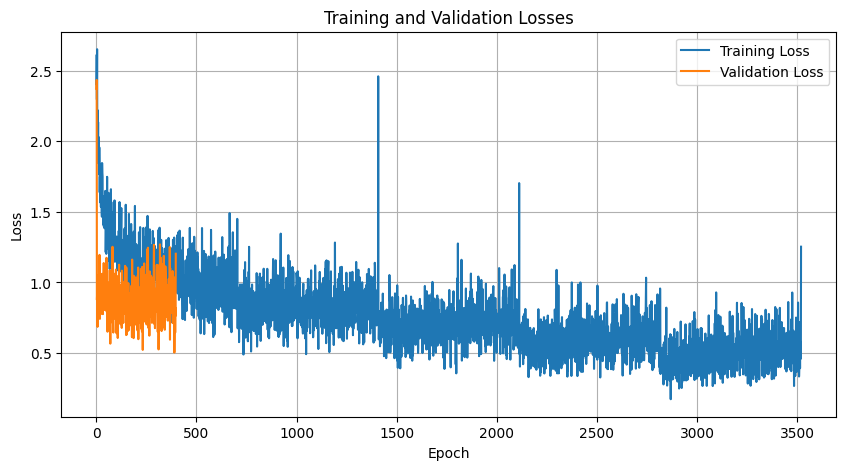

In [30]:
# Plot training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
epochs_train = range(1, len(model_transfer_learning.train_losses) + 1)
epochs_val = range(1, len(model_transfer_learning.val_losses) + 1)
plt.plot(epochs_train, model_transfer_learning.train_losses, label='Training Loss')
plt.plot(epochs_val, model_transfer_learning.val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Test the trained model
trainer.save_checkpoint("/content/transferLearning_model.ckpt")

trainer.test(model_transfer_learning, datamodule=datamodule_cifar10)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7069000005722046     │
│         test_loss         │    0.9082109332084656     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9082109332084656, 'test_acc': 0.7069000005722046}]